In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

data_folder = "data"
article_files = ["articles2019-05-31_0-7000.csv",
                 "articles2019-05-31_7000-14000.csv",
                 "articles2019-05-31_14000-16654.csv"]
article_df = [readArticles(os.path.join(data_folder, file)) for file in article_files]

article_df = pd.concat(article_df)
article_df = article_df.reset_index()
article_df.head()

,index,id,publisher,scrape_time,on_homepage,url,title,text,fingerprint,event,doc
0,0,0,sfgate.com,2019-05-31T07:45:29-04:00,False,https://www.sfgate.com/news/article/Beto-O-Rou...,"Beto O'Rourke bolstering Iowa staff, field off...","Beto O'Rourke bolstering Iowa staff, field off...","{'wordCounts': {'31293': 2, '38276': 5, '15430...",NaN,None
1,1,1,centurylink.net/news,2019-05-31T11:36:56-04:00,True,https://centurylink.net/news/read/category/new...,Robbins Geller Rudman & Dowd LLP Announces Pro...,TO: ### ALL PERSONS WHO PURCHASED DIPLOMAT PHA...,"{'wordCounts': {'744': 3, '421': 3, '13018': 5...",NaN,None
2,2,2,news.google.com,2019-05-31T15:32:23-04:00,True,https://news.google.com/stories/CAAqOQgKIjNDQk...,NaN,iMoreverified_user ### iMore ### From buying u...,"{'wordCounts': {'710161': 1, '403001': 1, '226...",NaN,None
3,3,3,zerohedge.com,2019-05-31T09:23:14-04:00,True,https://www.zerohedge.com/news/2019-05-31/stun...,Stunned Wall Street Responds To Trump's Shock ...,0 ### SHARES ### Just as the trade war with Ch...,"{'wordCounts': {'1169': 1, '310': 2, '127': 22...",6.0,None
4,4,4,washingtonpost.com,2019-05-31T07:18:53-04:00,False,https://www.washingtonpost.com/opinions/behind...,Behind the Iraq invasi,Former secretary of state Colin Powell in Wash...,"{'wordCounts': {'3000': 2, '17': 3, '7289': 2,...",NaN,None


In [2]:
events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]

In [3]:
import json
event_path = os.path.join(data_folder, "eventDict2019-05-31.json")

with open(event_path, encoding = "utf8") as json_file:
    events = json.load(json_file)

len(events['singletons'])

10683

In [20]:
sample = article_df.loc[random.sample(events['singletons'], 200), "id"]
#sample = article_df.loc[article_df["event"] == events[5], "id"]

start = time.time()

ac = tc.ArticleComparisons(thresh_jaccard = .25, thresh_same_sent = .9, thresh_same_doc = .25)
article_dict = dict_by_ids(article_df, sample)

score_mat = ac.jac_score_mat(article_dict, weighted = False)
axislabels = list(article_dict.keys())
axislabels

print("%s seconds taken" % np.round(time.time() - start, 2))
# 1000 comparisons takes ~15s: estimated >2 hours for 1000 articles 
# takes about ~1min for 100 docs, ~4min for 120 docs (44%), ~28min for 321 docs (event 6, 62%), 
# 100 singleton articles: 96%, 200 (10min): 93%

0 / 200 done, 0.0 seconds elapsed
20 / 200 done, 179.87 seconds elapsed
40 / 200 done, 293.55 seconds elapsed
60 / 200 done, 360.66 seconds elapsed
80 / 200 done, 428.94 seconds elapsed
100 / 200 done, 503.53 seconds elapsed
120 / 200 done, 558.36 seconds elapsed
140 / 200 done, 604.19 seconds elapsed
160 / 200 done, 626.25 seconds elapsed
180 / 200 done, 648.15 seconds elapsed
680.11 seconds taken


In [11]:
event6 = ac.get_article_clusters()
event6

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 1,
 23,
 3,
 24,
 25,
 26,
 27,
 16,
 28,
 29,
 30,
 31,
 32,
 10,
 33,
 34,
 35,
 16,
 36,
 3,
 37,
 38,
 39,
 40,
 41,
 42,
 4,
 43,
 44,
 18,
 33,
 45,
 46,
 47,
 48,
 49,
 50,
 37,
 51,
 25,
 37,
 52,
 53,
 54,
 7,
 55,
 56,
 57,
 5,
 58,
 59,
 45,
 60,
 61,
 62,
 4,
 10,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 47,
 72,
 73,
 74,
 74,
 75,
 19,
 76,
 77,
 34,
 78,
 79,
 76,
 80,
 73,
 81,
 82,
 83,
 65,
 84,
 3,
 74,
 85,
 42,
 86,
 87,
 10,
 88,
 7,
 27,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 79,
 7,
 37,
 16,
 96,
 97,
 98,
 52,
 50,
 99,
 7,
 100,
 47,
 25,
 101,
 2,
 102,
 103,
 104,
 105,
 10,
 27,
 106,
 107,
 76,
 98,
 108,
 109,
 110,
 88,
 90,
 111,
 3,
 112,
 113,
 114,
 115,
 116,
 117,
 98,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 25,
 125,
 126,
 127,
 47,
 74,
 128,
 129,
 130,
 124,
 131,
 132,
 0,
 133,
 134,
 135,
 67,
 136,
 137,
 48,
 3,
 138,
 50,
 3,
 

In [22]:
ac.get_article_clusters()
ac.prop_unique_clusters()

0.93

Average % unique articles in clusters, weighted by cluster size:  0.5370874263261297


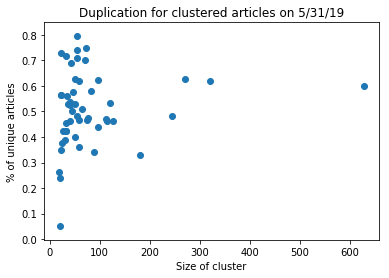

In [51]:
results = pd.read_csv("results_20190531.csv")
plt.scatter(results.loc[:, "n"], results.loc[:, "unique"])
plt.title("Duplication for clustered articles on 5/31/19")
plt.xlabel("Size of cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles in clusters, weighted by cluster size: ", np.sum(results.loc[:, "n"] * results.loc[:, "unique"])/np.sum(results.loc[:, "n"]))